In [1]:
print("strawberry")

strawberry


In [2]:
import torch
import numpy as np

# dataset
from twaidata.torchdatasets.in_ram_ds import MRISegmentation2DDataset, MRISegmentation3DDataset
from torch.utils.data import DataLoader, random_split, ConcatDataset

# model
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_DDU import HyperMapp3rDDU
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_SSN import HyperMapp3rSSN


# augmentation and pretrain processing
from trustworthai.utils.augmentation.standard_transforms import RandomFlip, GaussianBlur, GaussianNoise, \
                                                            RandomResizeCrop, RandomAffine, \
                                                            NormalizeImg, PairedCompose, LabelSelect, \
                                                            PairedCentreCrop, CropZDim
# loss function
from trustworthai.utils.losses_and_metrics.per_individual_losses import (
    dice_loss,
    log_cosh_dice_loss,
    TverskyLoss,
    FocalTverskyLoss,
    DiceLossMetric
)
from torch.nn import BCELoss, MSELoss, BCEWithLogitsLoss

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import pytorch_lightning as pl

# misc
import os
import torch
import matplotlib.pyplot as plt
import torch
from torchinfo import summary

### Set the seed

In [3]:
seed = 3407
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### define datasets and dataloaders

In [4]:
is3D = False

In [5]:
root_dir = "/disk/scratch/s2208943/ipdis/preprep/out_data/collated/"
#root_dir = "/media/benp/NVMEspare/datasets/preprocessing_attempts/local_results/collated/"
wmh_dir = root_dir + "WMH_challenge_dataset/"
ed_dir = root_dir + "EdData/"

In [6]:
# domains = [
#             wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
#           ]

# domains = [
#             wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
#           ] + [
#             ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
#           ]


domains = [
            ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
          ]

In [7]:
# augmentation definintion
def get_transforms(is_3D):
    transforms = [
        LabelSelect(label_id=1),
        RandomFlip(p=0.5, orientation="horizontal"),
        # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
        GaussianNoise(p=0.8, mean=0, sigma=0.1),
        # RandomAffine(p=0.2, shear=(.1,3.)),
        # RandomAffine(p=0.2, degrees=5),
        #RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))
        
        
        RandomResizeCrop(p=1., scale=(0.3, 0.5), ratio=(3./4., 4./3.)) # ssn
    ]
    if not is_3D:
        transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
        return PairedCompose(transforms)
    else:
        transforms.append(CropZDim(size=32, minimum=0, maximum=-1))
        transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
        return PairedCompose(transforms)

In [8]:
#transforms = get_transforms(is_3D)

In [9]:
# function to do train validate test split
test_proportion = 0.1
validation_proportion = 0.2

def train_val_test_split(dataset, val_prop, test_prop, seed):
    # I think the sklearn version might be prefereable for determinism and things
    # but that involves fiddling with the dataset implementation I think....
    size = len(dataset)
    test_size = int(test_prop*size) 
    val_size = int(val_prop*size)
    train_size = size - val_size - test_size
    train, val, test = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))
    return train, val, test

In [10]:
# load datasets
# this step is quite slow, all the data is being loaded into memory
if is3D:
    datasets_domains = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is_3D=True)) for domain in domains]
else:
    datasets_domains = [MRISegmentation2DDataset(root_dir, domain, transforms=get_transforms(is_3D=False)) for domain in domains]



In [11]:
# split into train, val test datasets
datasets = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains]

# concat the train val test datsets
train_dataset = ConcatDataset([ds[0] for ds in datasets])
val_dataset = ConcatDataset([ds[1] for ds in datasets])
test_dataset = ConcatDataset([ds[2] for ds in datasets])

In [12]:
len(train_dataset), len(val_dataset), len(test_dataset)

(8743, 2497, 1248)

In [13]:
# define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

In [29]:
import torch
import torch.nn as nn
from trustworthai.models.uq_models.drop_UNet import normalization_layer
import torch.nn.functional as F
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
import torch.distributions as td
from typing import Tuple


def get_conv_func(dims, transpose=False):
    # determine convolution func
        if dims == 2:
            if transpose:
                return nn.ConvTranspose2d
            else:
                return nn.Conv2d
        elif dims == 3:
            if transpose:
                return nn.ConvTranspose3d
            else:
                return nn.Conv3d
        else:
            raise ValueError(f"values of dims of 2 or 3 (2D or 2D conv) are supported only, not {dims}")
            
def get_dropout_func(dims):
    if dims == 2:
        return nn.Dropout2d
    if dims == 3:
        return nn.Dropout3d
    else:
        return nn.Dropout

class ReshapedDistribution(td.Distribution):
    def __init__(self, base_distribution: td.Distribution, new_event_shape: Tuple[int, ...]):
        super().__init__(batch_shape=base_distribution.batch_shape, event_shape=new_event_shape, validate_args=False)
        self.base_distribution = base_distribution
        self.new_shape = base_distribution.batch_shape + new_event_shape
        
        #print("base distribution: ", self.base_distribution)

    @property
    def support(self):
        return self.base_distribution.support

    @property
    def arg_constraints(self):
        return self.base_distribution.arg_constraints()

    @property
    def mean(self):
        return self.base_distribution.mean.view(self.new_shape)

    @property
    def variance(self):
        return self.base_distribution.variance.view(self.new_shape)

    def rsample(self, sample_shape=torch.Size()):
        return self.base_distribution.rsample(sample_shape).view(sample_shape + self.new_shape)

    def log_prob(self, value):
        return self.base_distribution.log_prob(value.view(self.batch_shape + (-1,)))

    def entropy(self):
        return self.base_distribution.entropy()    
    
class HyperMapp3rSSN2(HyperMapp3r):
    def __init__(self, dims=3,
                 in_channels=3,
                 out_channels=1,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=True,
                 up_res_blocks=False,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 },
                 ssn_rank = 10,
                 ssn_epsilon=1e-5,
                 ssn_diagonal=False
                ):
        super().__init__(dims=dims,
                 in_channels=in_channels,
                 out_channels=decoder_features[-1], # last layer of just keeps number of nodes fixed this time
                 encoder_features=encoder_features,
                 decoder_features=decoder_features,
                 softmax=False,
                 up_res_blocks=up_res_blocks,
                 block_params=block_params)
        
        print("WARNING: this model assumes that the input to the model contains the brain mask in the first channel!")
        conv_func = get_conv_func(dims, transpose=False)
        self.ssn_rank = ssn_rank
        self.ssn_diagonal = ssn_diagonal
        self.ssn_epsilon = ssn_epsilon
        self.ssn_num_classes = out_channels
        
        self.lrelu = nn.LeakyReLU(0.01)
        
        self.mean_l = conv_func(decoder_features[-1], out_channels, kernel_size = (1,) *  dims, padding='same')
        self.log_cov_diag_l = conv_func(decoder_features[-1], out_channels, kernel_size = (1,) * dims, padding='same')
        self.cov_factor_l = conv_func(decoder_features[-1], out_channels * ssn_rank, kernel_size = (1,) * dims, padding='same')

    def forward(self, x):
        logits = self.lrelu(super().forward(x))
        if torch.sum(torch.isnan(logits)) > 0:
            print("NAN 1", torch.sum(torch.isnan(logits)))
        batch_size = logits.shape[0]
        event_shape = (self.ssn_num_classes,) + logits.shape[2:]
        
        mean = self.mean_l(logits)
        mean = mean.view((batch_size, -1))
        
        cov_diag = self.log_cov_diag_l(logits).exp() #+ 0.001
        cov_diag = cov_diag.view((batch_size, -1))
        # print(torch.min(cov_diag))
        
        cov_factor = self.cov_factor_l(logits)
        cov_factor = cov_factor.view((batch_size, self.ssn_rank, self.ssn_num_classes, -1))
        cov_factor = cov_factor.flatten(2,3)
        cov_factor = cov_factor.transpose(1,2)
        if torch.sum(torch.isnan(mean)) > 0:
            print("NAN 2")
        if torch.sum(torch.isnan(cov_diag)) > 0:
            print("NAN 3")
        if torch.sum(torch.isnan(cov_factor)) > 0:
            print("NAN 4")
        
        # covariance tends to blow up to infinity, hence set to 0 outside the ROI
        mask = x[:,1]
        # print(torch.min(mask), torch.max(mask))
        mask = mask.unsqueeze(1).expand((batch_size, self.ssn_num_classes) + mask.shape[1:]).reshape(batch_size, -1)
        cov_factor = cov_factor * mask.unsqueeze(-1)
        cov_diag = (cov_diag * mask) + self.ssn_epsilon
        
        if torch.sum(torch.isnan(mask)) > 0:
            print("NAN 5")
        if torch.sum(torch.isnan(cov_factor)) > 0:
            print("NAN 6")
        if torch.sum(torch.isnan(cov_diag)) > 0:
            print("NAN 7")
        
        if self.ssn_diagonal:
            # print(torch.min(torch.sqrt(cov_diag)))
            base_distribution = td.Independent(td.Normal(loc=mean, scale=torch.sqrt(cov_diag)), 1)
        else:
            try:
                # print(torch.min(cov_diag))
                base_distribution = td.LowRankMultivariateNormal(loc=mean, cov_factor=cov_factor, cov_diag=cov_diag)
                #print("using multivariate normal!")
            except Exception as e:
                print("was thrown: ", e)
                print('hmm: Covariance became non invertible using independent normals for this batch!')
                print("cov diag okay: ", torch.sum(cov_diag <=0))
                print("sqrt cov diag okay: ", torch.sum(torch.sqrt(cov_diag) <=0))
                
                try:
                    base_distribution = td.Independent(td.Normal(loc=mean, scale=torch.sqrt(cov_diag)),1)
                except Exception as e:
                    print("second fail: ", e)
                    print(torch.min(torch.sqrt(cov_diag), torch.max(torch.sqrt(cov_diag))))
        
        distribution = ReshapedDistribution(base_distribution, event_shape)
        
        shape = (batch_size,) + event_shape
        logit_mean_view = mean.view(shape).detach()
        cov_diag_view = cov_diag.view(shape).detach()
        cov_factor_view = cov_factor.transpose(2,1).view((batch_size, self.ssn_num_classes * self.ssn_rank) + event_shape[1:]).detach()
        
        
        output_dict = {
            'logit_mean':logit_mean_view,
            'cov_diag':cov_diag_view,
            'cov_factor':cov_factor_view,
            'distribution':distribution,
        }
        
        return output_dict

### setup model

In [30]:
in_channels = 3
out_channels = 1

if is3D:
    pass
else:
    # encoder_features=[16, 32, 64, 128, 256] # orig: [16, 32, 64, 128, 256]
    # decoder_features=encoder_features[::-1][1:]
#     model = HyperMapp3r(dims=2,
#                  in_channels=3,
#                  out_channels=2,
#                  encoder_features=[16, 32, 64, 128, 256],
#                  decoder_features=[128, 64, 32, 16],
#                  softmax=False,
#                  up_res_blocks=False,
#                  block_params={
#                      "dropout_p":0.1,
#                      "norm_type":"in", 
#                      "dropout_both_layers":False,
#                  }
#                    )
    
    # model = HyperMapp3rDDU(dims=2,
    #              in_channels=3,
    #              out_channels=2,
    #              encoder_features=[16, 32, 64, 128, 256],
    #              decoder_features=[128, 64, 32, 16],
    #              softmax=False,
    #              up_res_blocks=True,
    #              n_power_iterations=3, 
    #              eps=1e-12,
    #              block_params={
    #                  "dropout_p":0.1,
    #                  "norm_type":"in", 
    #                  "dropout_both_layers":False,
    #              }
    #                )
    
    model_raw = HyperMapp3rSSN2(dims=2,
                 in_channels=3,
                 out_channels=2,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=True,
                 up_res_blocks=False,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 },
                 ssn_rank = 10,
                 ssn_epsilon=1e-5,
                 ssn_diagonal=False)
    
    #optimizer_params={"lr":2e-3}
    #lr_scheduler_params={"step_size":20, "gamma":0.1}
    # optimizer_params={"lr":2e-3, "momentum":0.6}
    # optimizer = torch.optim.RMSprop
    # lr_scheduler_params={"milestones":[10,100,200], "gamma":0.5}
    # lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR


In [31]:
summary(model_raw)

Layer (type:depth-idx)                   Param #
HyperMapp3rSSN2                          --
├─ModuleList: 1-1                        --
│    └─HM3Block: 2-1                     --
│    │    └─Conv2d: 3-1                  2,304
│    │    └─Dropout2d: 3-2               --
│    │    └─InstanceNorm2d: 3-3          --
│    │    └─Conv2d: 3-4                  2,304
│    │    └─InstanceNorm2d: 3-5          --
│    │    └─LeakyReLU: 3-6               --
│    └─HM3Block: 2-2                     --
│    │    └─Conv2d: 3-7                  9,216
│    │    └─Dropout2d: 3-8               --
│    │    └─InstanceNorm2d: 3-9          --
│    │    └─Conv2d: 3-10                 9,216
│    │    └─InstanceNorm2d: 3-11         --
│    │    └─LeakyReLU: 3-12              --
│    └─HM3Block: 2-3                     --
│    │    └─Conv2d: 3-13                 36,864
│    │    └─Dropout2d: 3-14              --
│    │    └─InstanceNorm2d: 3-15         --
│    │    └─Conv2d: 3-16                 36,864
│    │ 

In [32]:
#model.load_state_dict(torch.load("ssn_trained_no_wrapper_class.ckpt"))

In [33]:
import pytorch_lightning as pl

import torch
import torch.nn as nn
import torch.nn.functional as F

class StandardLitModelWrapper(pl.LightningModule):
    def __init__(self, model, loss=F.cross_entropy, logging_metric=None, optimizer_params={"lr":1e-3}, lr_scheduler_params={"step_size":30, "gamma":0.1}, is_uq_model=False,
                optimizer_constructor=None, lr_scheduler_constructor=None):
        super().__init__()
        self.model = model
        self.loss = loss
        self.logging_metric_train = logging_metric()
        self.logging_metric_val = logging_metric()
        self.optim_params = optimizer_params
        self.lr_scheduler_params = lr_scheduler_params
        self.is_uq_model = False
        self.optimizer_constructor = optimizer_constructor
        self.lr_scheduler_constructor = lr_scheduler_constructor

        
    def forward(self, x, **kwargs):
        return self.model(x, **kwargs)
    
    def configure_optimizers(self):
        # optimizer and schedulers go in the configure optimizers hook
        if self.optimizer_constructor:
            optimizer = self.optimizer_constructor(self.parameters(), **self.optim_params)
        else:
            optimizer = torch.optim.Adam(self.parameters(), **self.optim_params)
        
        if self.lr_scheduler_constructor:
            lr_scheduler = self.lr_scheduler_constructor(optimizer, **self.lr_scheduler_params)
        else:
            lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, **self.lr_scheduler_params)
        
        return [optimizer], [lr_scheduler]
    
    def training_step(self, batch, batch_idx):
        """
        lightning automates the training loop, 
        does epoch, back_tracking, optimizers and schedulers,
        and metric reduction.
        we just define how we want to process a single batch. 
        we can optionally pass optimizer_idx if we want to define multiple optimizers within the configure_optimizers
        hook, and I presume we can add our own parameters also to functions?
        """
        
        if self.is_uq_model:
            self.model.set_applyfunc(True)
        
        X, y = batch
        y_hat = self(X)
        loss = self.loss(y_hat, y)
        
        # metrics 
        if self.logging_metric_train:
            self.logging_metric_train(y_hat, y)
            self.log(f"train_metric", self.logging_metric_train, on_step=True, on_epoch=False, prog_bar=True)
        self.log("train_loss", loss)
        
        return loss
    
#     def training_epoch_end(self, outs):
#         self.log('train_metric_epoch', self.logging_metric_train.compute())
        
#     def validation_epoch_end(self, outs):
#         self.log('val_metric_epoch', self.logging_metric_val.compute())
    
    def validation_step(self, batch, batch_idx):
        """
        note: call trainer.validate() automatically loads the best checkpoint if checkpointing was enabled during fitting
        well yes I want to enable checkpointing but will deal with that later.
        also it does stuff like model.eval() and torch.no_grad() automatically which is nice.
        I will need a custom eval thing to do my dropout estimation but can solve that later too.
        """
        if self.is_uq_model:
            self.model.set_applyfunc(False)
        
        X, y = batch
        y_hat = self(X)
        val_loss = self.loss(y_hat, y)
        
        if self.logging_metric_val:
            self.logging_metric_val(y_hat, y)
            self.log(f"val_metric", self.logging_metric_val, on_step=True, on_epoch=True, prog_bar=True)
        self.log("val_loss", val_loss)
        
    def test_step(self, batch, batch_idx):
        """
        we would need to directly call this function using the trainer
        """
        
        if self.is_uq_model:
            self.model.set_applyfunc(False)
        
        X, y = batch
        y_hat = self(X)
        test_loss = self.loss(y_hat, y)
        self.log("test_loss", test_loss)
        
    def predict_step(self, batch, batch_idx):
        """
        just for making predictions as opposed to collecting metrics etc
        note to use this, we just call .predict(dataloader) and it then automates the look
        these functions are for a single batch. Nice.
        """
        X, y = batch
        pred = self(X)
        return pred

In [34]:
#loss = dice_loss
#loss = torch.nn.CrossEntropyLoss(weight=torch.Tensor([0.968, 0.032]))
#loss = FocalLoss(gamma=1., reduction='mean', alpha=torch.Tensor([1-0.968, 1-0.032]))
#loss = log_cosh_dice_loss
#loss = TverskyLoss(beta=0.7)
#loss = FocalTverskyLoss(beta=0.7, gamma=0.8)

In [35]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import math


class StochasticSegmentationNetworkLossMCIntegral(nn.Module):
    def __init__(self, num_mc_samples: int = 1):
        super().__init__()
        self.num_mc_samples = num_mc_samples

    @staticmethod
    def fixed_re_parametrization_trick(dist, num_samples):
        assert num_samples % 2 == 0
        samples = dist.rsample((num_samples // 2,))
        mean = dist.mean.unsqueeze(0)
        samples = samples - mean
        return torch.cat([samples, -samples]) + mean

    def forward(self, result_dict, target, **kwargs):
        logits = result_dict['logit_mean']
        distribution = result_dict['distribution']
        
        batch_size = logits.shape[0]
        num_classes = logits.shape[1]
        assert num_classes >= 2  # not implemented for binary case with implied background
        # logit_sample = distribution.rsample((self.num_mc_samples,))
        logit_sample = self.fixed_re_parametrization_trick(distribution, self.num_mc_samples)
        target = target.unsqueeze(1)
        target = target.expand((self.num_mc_samples,) + target.shape)

        flat_size = self.num_mc_samples * batch_size
        logit_sample = logit_sample.view((flat_size, num_classes, -1))
        target = target.reshape((flat_size, -1))

        log_prob = -F.cross_entropy(logit_sample, target, reduction='none').view((self.num_mc_samples, batch_size, -1))
        loglikelihood = torch.mean(torch.logsumexp(torch.sum(log_prob, dim=-1), dim=0) - math.log(self.num_mc_samples))
        loss = -loglikelihood
        return loss

In [36]:
def fixed_re_parametrization_trick(dist, num_samples):
        assert num_samples % 2 == 0
        samples = dist.rsample((num_samples // 2,))
        mean = dist.mean.unsqueeze(0)
        samples = samples - mean
        return torch.cat([samples, -samples]) + mean


class SsnNetworkMeanLossWrapper(nn.Module):
    def __init__(self, loss_func):
        super().__init__()
        self.loss = loss_func
    def forward(self, result_dict, target):
        mean = result_dict['logit_mean']
        return self.loss(mean, target)
    
class SsnNetworkSampleLossWrapper(nn.Module):
    def __init__(self, loss_func, samples=10):
        super().__init__()
        self.loss = loss_func
        self.samples = samples
    def forward(self, result_dict, target):
        samples = fixed_re_parametrization_trick(result_dict['distribution'], self.samples).to(target.device)
        loss = 0
        for s in samples:
            loss += self.loss(s, target)
        return loss / self.samples
        #return torch.mean(torch.Tensor(losses))

In [37]:
class SsnDiceMetricWrapper(DiceLossMetric):

    def update(self, preds_dict, target: torch.Tensor):
        super().update(preds_dict['logit_mean'], target)

    def compute(self):
        return super().compute()

In [38]:
ssn_diceloss = SsnNetworkSampleLossWrapper(dice_loss)# SsnNetworkMeanLossWrapper(dice_loss)
mc_loss = StochasticSegmentationNetworkLossMCIntegral(num_mc_samples=10)

def double_loss(outs, target):
    return ssn_diceloss(outs, target) * 10 + mc_loss(outs, target) * 0.01

In [39]:
# loss = StochasticSegmentationNetworkLossMCIntegral(num_mc_samples=10)
# loss = SsnNetworkSampleLossWrapper(dice_loss)
loss = double_loss

In [40]:
#optimizer_params={"lr":2e-4, "momentum":0.6}
optimizer_params={"lr":1e-3}
optimizer = torch.optim.Adam
lr_scheduler_params={"milestones":[100,200], "gamma":0.5}
lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR

In [41]:
model = StandardLitModelWrapper(model_raw, loss, 
                                logging_metric=SsnDiceMetricWrapper,
                                optimizer_params=optimizer_params,
                                lr_scheduler_params=lr_scheduler_params,
                                is_uq_model=False,
                                optimizer_constructor=optimizer,
                                lr_scheduler_constructor=lr_scheduler_constructor
                               )


# checkpoint= "ed_domains_ssn_trained.ckpt"
# model = StandardLitModelWrapper.load_from_checkpoint(checkpoint, model=model_raw, loss=double_loss, logging_metric=SsnDiceMetricWrapper, lr_scheduler_params=lr_scheduler_params,
#                                 is_uq_model=False,
#                                 optimizer_constructor=optimizer,
#                                 lr_scheduler_constructor=lr_scheduler_constructor)

In [42]:
checkpoint_dir = "./lightning_logs"
strategy = None
# strategy = "deepspeed_stage_2"
# strategy = "dp"
#strategy = "deepspeed_stage_2_offload"

accelerator="gpu"
devices=1
max_epochs=500
precision = 32

checkpoint_callback = ModelCheckpoint(checkpoint_dir, save_top_k=2, monitor="val_loss")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=500, verbose="False", mode="min", check_finite=True)
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator=accelerator,
    devices=devices,
    max_epochs=max_epochs,
    strategy=strategy,
    precision=precision,
    default_root_dir=checkpoint_dir
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### train

In [43]:
trainer.fit(model, train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type                 | Params
--------------------------------------------------------------
0 | model                | HyperMapp3rSSN2      | 2.8 M 
1 | logging_metric_train | SsnDiceMetricWrapper | 0     
2 | logging_metric_val   | SsnDiceMetricWrapper | 0     
--------------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.107    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 11.865


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.284 >= min_delta = 0.0. New best score: 9.581


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.104 >= min_delta = 0.0. New best score: 8.477


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.425 >= min_delta = 0.0. New best score: 8.052


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 8.009


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.173 >= min_delta = 0.0. New best score: 7.836


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.434 >= min_delta = 0.0. New best score: 7.402


Validation: 0it [00:00, ?it/s]

was thrown:  torch.linalg_cholesky: (Batch element 50): The factorization could not be completed because the input is not positive-definite (the leading minor of order 10 is not positive-definite).
hmm: Covariance became non invertible using independent normals for this batch!
cov diag okay:  tensor(0, device='cuda:0')
sqrt cov diag okay:  tensor(0, device='cuda:0')


Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 7.387


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.239 >= min_delta = 0.0. New best score: 7.148


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.149 >= min_delta = 0.0. New best score: 6.999


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 6.994


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.085 >= min_delta = 0.0. New best score: 6.908


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.077 >= min_delta = 0.0. New best score: 6.831


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.112 >= min_delta = 0.0. New best score: 6.719


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 6.657


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.182 >= min_delta = 0.0. New best score: 6.475


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

was thrown:  torch.linalg_cholesky: (Batch element 12): The factorization could not be completed because the input is not positive-definite (the leading minor of order 10 is not positive-definite).
hmm: Covariance became non invertible using independent normals for this batch!
cov diag okay:  tensor(0, device='cuda:0')
sqrt cov diag okay:  tensor(0, device='cuda:0')


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 6.419


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 6.407
/home/s2208943/miniconda3/envs/ip/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:724: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [45]:
trainer.validate(model, val_dataloader, ckpt_path='best')

Restoring states from the checkpoint path at /home/s2208943/ipdis/Trustworthai-MRI-WMH/trustworthai/models/uq_models/initial_variants/ssn/lightning_logs/epoch=29-step=4110.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/Trustworthai-MRI-WMH/trustworthai/models/uq_models/initial_variants/ssn/lightning_logs/epoch=29-step=4110.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            6.3752617835998535
    val_metric_epoch        0.26374727487564087
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_metric_epoch': 0.26374727487564087, 'val_loss': 6.3752617835998535}]

In [46]:
def entropy_map_from_samples(samples):
    "samples is of shape samples, batch size, channels, image dims  [s, b, c *<dims>]"
    probs = torch.nn.functional.softmax(samples, dim=2)
    pic = torch.mean(probs, dim=0)
    ent_map = torch.sum(-pic * torch.log(pic+1e-30), dim=1)
    
    return ent_map

In [47]:
from tqdm import tqdm

In [48]:
all_tps = []
all_tns = []
all_fps = []
all_fns = []

with torch.no_grad():
    for x, y in tqdm(val_dataloader, position=0, leave=True, ncols=150):
        pred = model(x)
        samples = fixed_re_parametrization_trick(pred['distribution'], 14).cpu()
        ent = entropy_map_from_samples(samples).view([-1])
        mean = pred['logit_mean']
        mean_class = mean.argmax(dim=1).view(-1)
        y_flat = y.view(-1)
        
        tp_loc = torch.where(torch.logical_and(y_flat == 1, mean_class == 1))[0]
        tn_loc = torch.where(torch.logical_and(torch.logical_and(y_flat == 0, mean_class == 0), x[:,1].reshape(-1) == 1))[0]
        fp_loc = torch.where(torch.logical_and(y_flat == 0, mean_class == 1))[0]
        fn_loc = torch.where(torch.logical_and(torch.logical_and(y_flat == 1, mean_class == 0), x[:,1].reshape(-1) == 1))[0]
        # print(tp_loc.shape)
        # print(ent.view(-1).shape)
        
        all_tps.append(ent[tp_loc])
        all_tns.append(ent[tn_loc])
        all_fps.append(ent[fp_loc])
        all_fns.append(ent[fn_loc])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [02:57<00:00,  4.45s/it]


In [49]:
tps = torch.cat(all_tps)
tns = torch.cat(all_tns)
fps = torch.cat(all_fps)
fns = torch.cat(all_fns)

In [50]:
tps.shape, tns.shape, fps.shape, fns.shape

(torch.Size([575652]),
 torch.Size([39656163]),
 torch.Size([144636]),
 torch.Size([224149]))

In [51]:
tps.mean(), tns.mean(), fps.mean(), fns.mean()

(tensor(0.3016), tensor(0.0142), tensor(0.5476), tensor(0.4165))

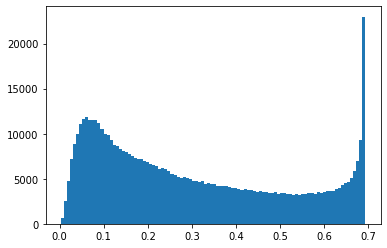

In [52]:
plt.hist(tps, bins=100);

In [53]:
#plt.hist(tns, bins=100);

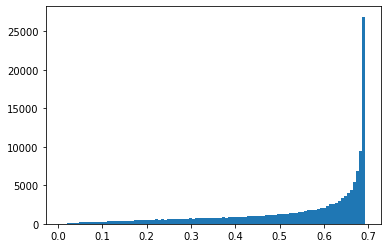

In [54]:
plt.hist(fps, bins=100);

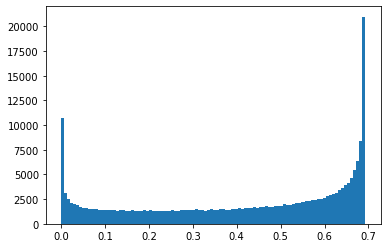

In [55]:
plt.hist(fns, bins=100);

### count the number of missing lesions per image.

In [58]:
from typing import Dict, Tuple

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np
import kornia as K

def create_random_labels_map(classes: int) -> Dict[int, Tuple[int, int, int]]:
    labels_map: Dict[int, Tuple[int, int, int]] = {}
    for i in classes:
        labels_map[i] = torch.randint(0, 255, (3, ))
    labels_map[0] = torch.zeros(3)
    return labels_map

def labels_to_image(img_labels: torch.Tensor, labels_map: Dict[int, Tuple[int, int, int]]) -> torch.Tensor:
    """Function that given an image with labels ids and their pixels intrensity mapping, creates a RGB
    representation for visualisation purposes."""
    assert len(img_labels.shape) == 2, img_labels.shape
    H, W = img_labels.shape
    out = torch.empty(3, H, W, dtype=torch.uint8)
    for label_id, label_val in labels_map.items():
        mask = (img_labels == label_id)
        for i in range(3):
            out[i].masked_fill_(mask, label_val[i])
    return out

def show_components(img, labels):
    color_ids = torch.unique(labels)
    labels_map = create_random_labels_map(color_ids)
    labels_img = labels_to_image(labels, labels_map)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))
    
    # Showing Original Image
    ax1.imshow(img)
    ax1.axis("off")
    ax1.set_title("Orginal Image")
    
    #Showing Image after Component Labeling
    ax2.imshow(labels_img.permute(1,2,0).squeeze().numpy())
    ax2.axis('off')
    ax2.set_title("Component Labeling")

In [59]:
ys = []
conncomp_outs = []
ents_out = []
means_out = []
with torch.no_grad():
    for x, y in tqdm(val_dataloader, position=0, leave=True, ncols=150):
        labels_out = K.contrib.connected_components(y.unsqueeze(1).type(torch.float32), num_iterations=150)
        conncomp_outs.append(labels_out)
        ys.append(y)

        pred = model.cuda()(x.cuda())
        samples = fixed_re_parametrization_trick(pred['distribution'], 14).cpu()
        ents_out.append(entropy_map_from_samples(samples))
        means_out.append(pred['logit_mean'].cpu())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:57<00:00,  2.94s/it]


In [60]:
missing_lesion_size_ent = []
existing_lesion_size_ent = []
missing_lesion_size_mean = []
existing_lesion_size_mean = []
for batch in tqdm(range(len(ys)), position=0, leave=True, ncols=150):
    for i in range(ys[batch].shape[0]):
        conncomps = conncomp_outs[batch][i]
        ent = ents_out[batch][i]
        ent_thresh = (ent > 0.1).type(torch.long)
        mean = means_out[batch][i].argmax(dim=0).type(torch.long)
        
        ids = conncomps.unique()[1:]
        for idx in ids:
            cc = (conncomps == idx)
            size = torch.sum(cc)
            if torch.max(mean * cc) > 0:
                existing_lesion_size_mean.append(size)
            else:
                missing_lesion_size_mean.append(size)
            
            if torch.max(ent_thresh * cc) > 0:
                existing_lesion_size_ent.append(size)
            else:
                missing_lesion_size_ent.append(size)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:34<00:00,  1.16it/s]


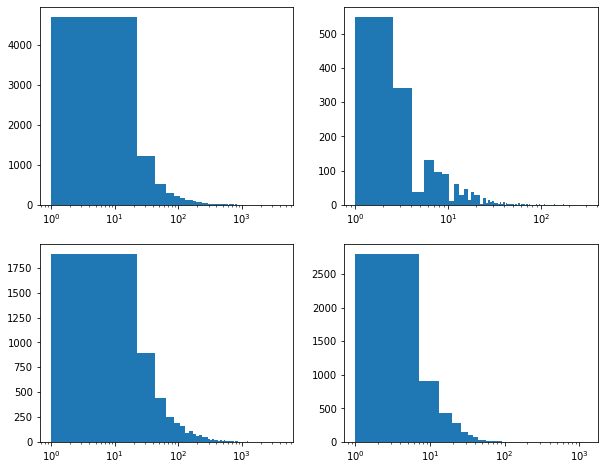

In [61]:
plt.figure(figsize=(10, 8))
plt.subplot(2,2,1)
plt.hist(existing_lesion_size_ent, bins=200);
plt.xscale('log')
plt.subplot(2,2,2)
plt.hist(missing_lesion_size_ent, bins=200);
plt.xscale('log')

plt.subplot(2,2,3)
plt.hist(existing_lesion_size_mean, bins=200);
plt.xscale('log')
plt.subplot(2,2,4)
plt.hist(missing_lesion_size_mean, bins=200);
plt.xscale('log')

In [62]:
print("means")
torch.Tensor(existing_lesion_size_ent).mean(), torch.Tensor(missing_lesion_size_ent).mean(), torch.Tensor(existing_lesion_size_mean).mean(), torch.Tensor(missing_lesion_size_mean).mean()

means


(tensor(94.0927), tensor(9.3081), tensor(146.9350), tensor(13.2946))

In [63]:
def slice_dice(y_hat, y_true):
    y_hat = torch.nn.functional.softmax(y_hat, dim=0).argmax(dim=0)
    
    if torch.sum(y_hat) == 0 and torch.sum(y_true) == 0:
        return "n/a"
    
    numerator = torch.sum(2 * y_hat * y_true)
    denominator = torch.sum(y_hat + y_true)
    return numerator / (denominator + 1e-8)

In [64]:
slice_dices = []
with torch.no_grad():
    for x, y in tqdm(val_dataloader, position=0, ncols=150, leave=True):
        pred = model.cuda()(x.cuda())
        samples = fixed_re_parametrization_trick(pred['distribution'], 14).cpu()
        
        for i in range(y.shape[0]):
            ind_dices = []
            for s in samples[:,i]:
                ind_dices.append(slice_dice(s, y[i]))
            slice_dices.append(ind_dices)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [06:36<00:00,  9.92s/it]


In [65]:
# remove na images 
filtered_slice_dices = [x for x in slice_dices if 'n/a' not in x]

In [66]:
means = [torch.mean(torch.Tensor(x)) for x in filtered_slice_dices]

In [67]:
inds = torch.Tensor(means).sort()[1]

In [68]:
random_selection_inds = inds[torch.randint(0, len(inds), (200,)).sort()[0]]

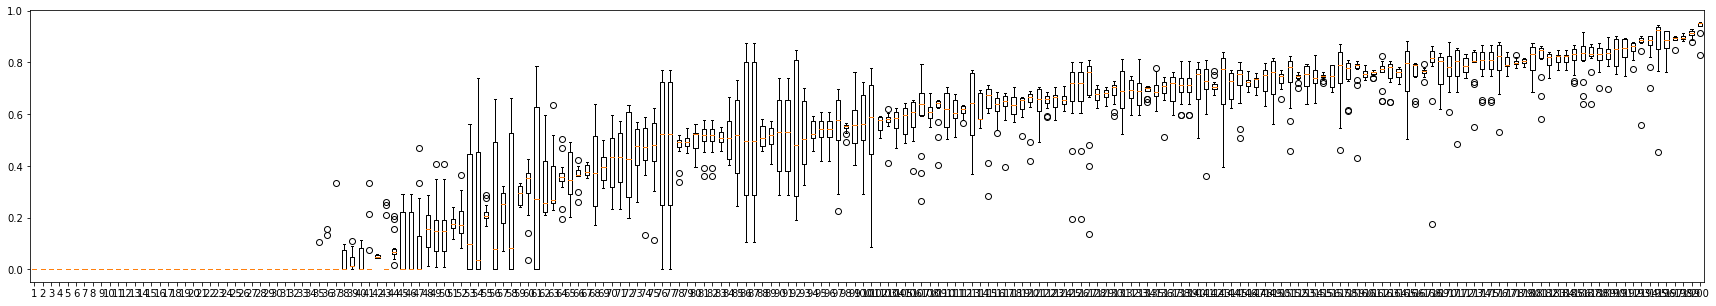

In [69]:
plt.figure(figsize=(30, 5))
plt.boxplot(torch.Tensor(filtered_slice_dices)[random_selection_inds]);

In [70]:
x, y, = next(iter(val_dataloader))

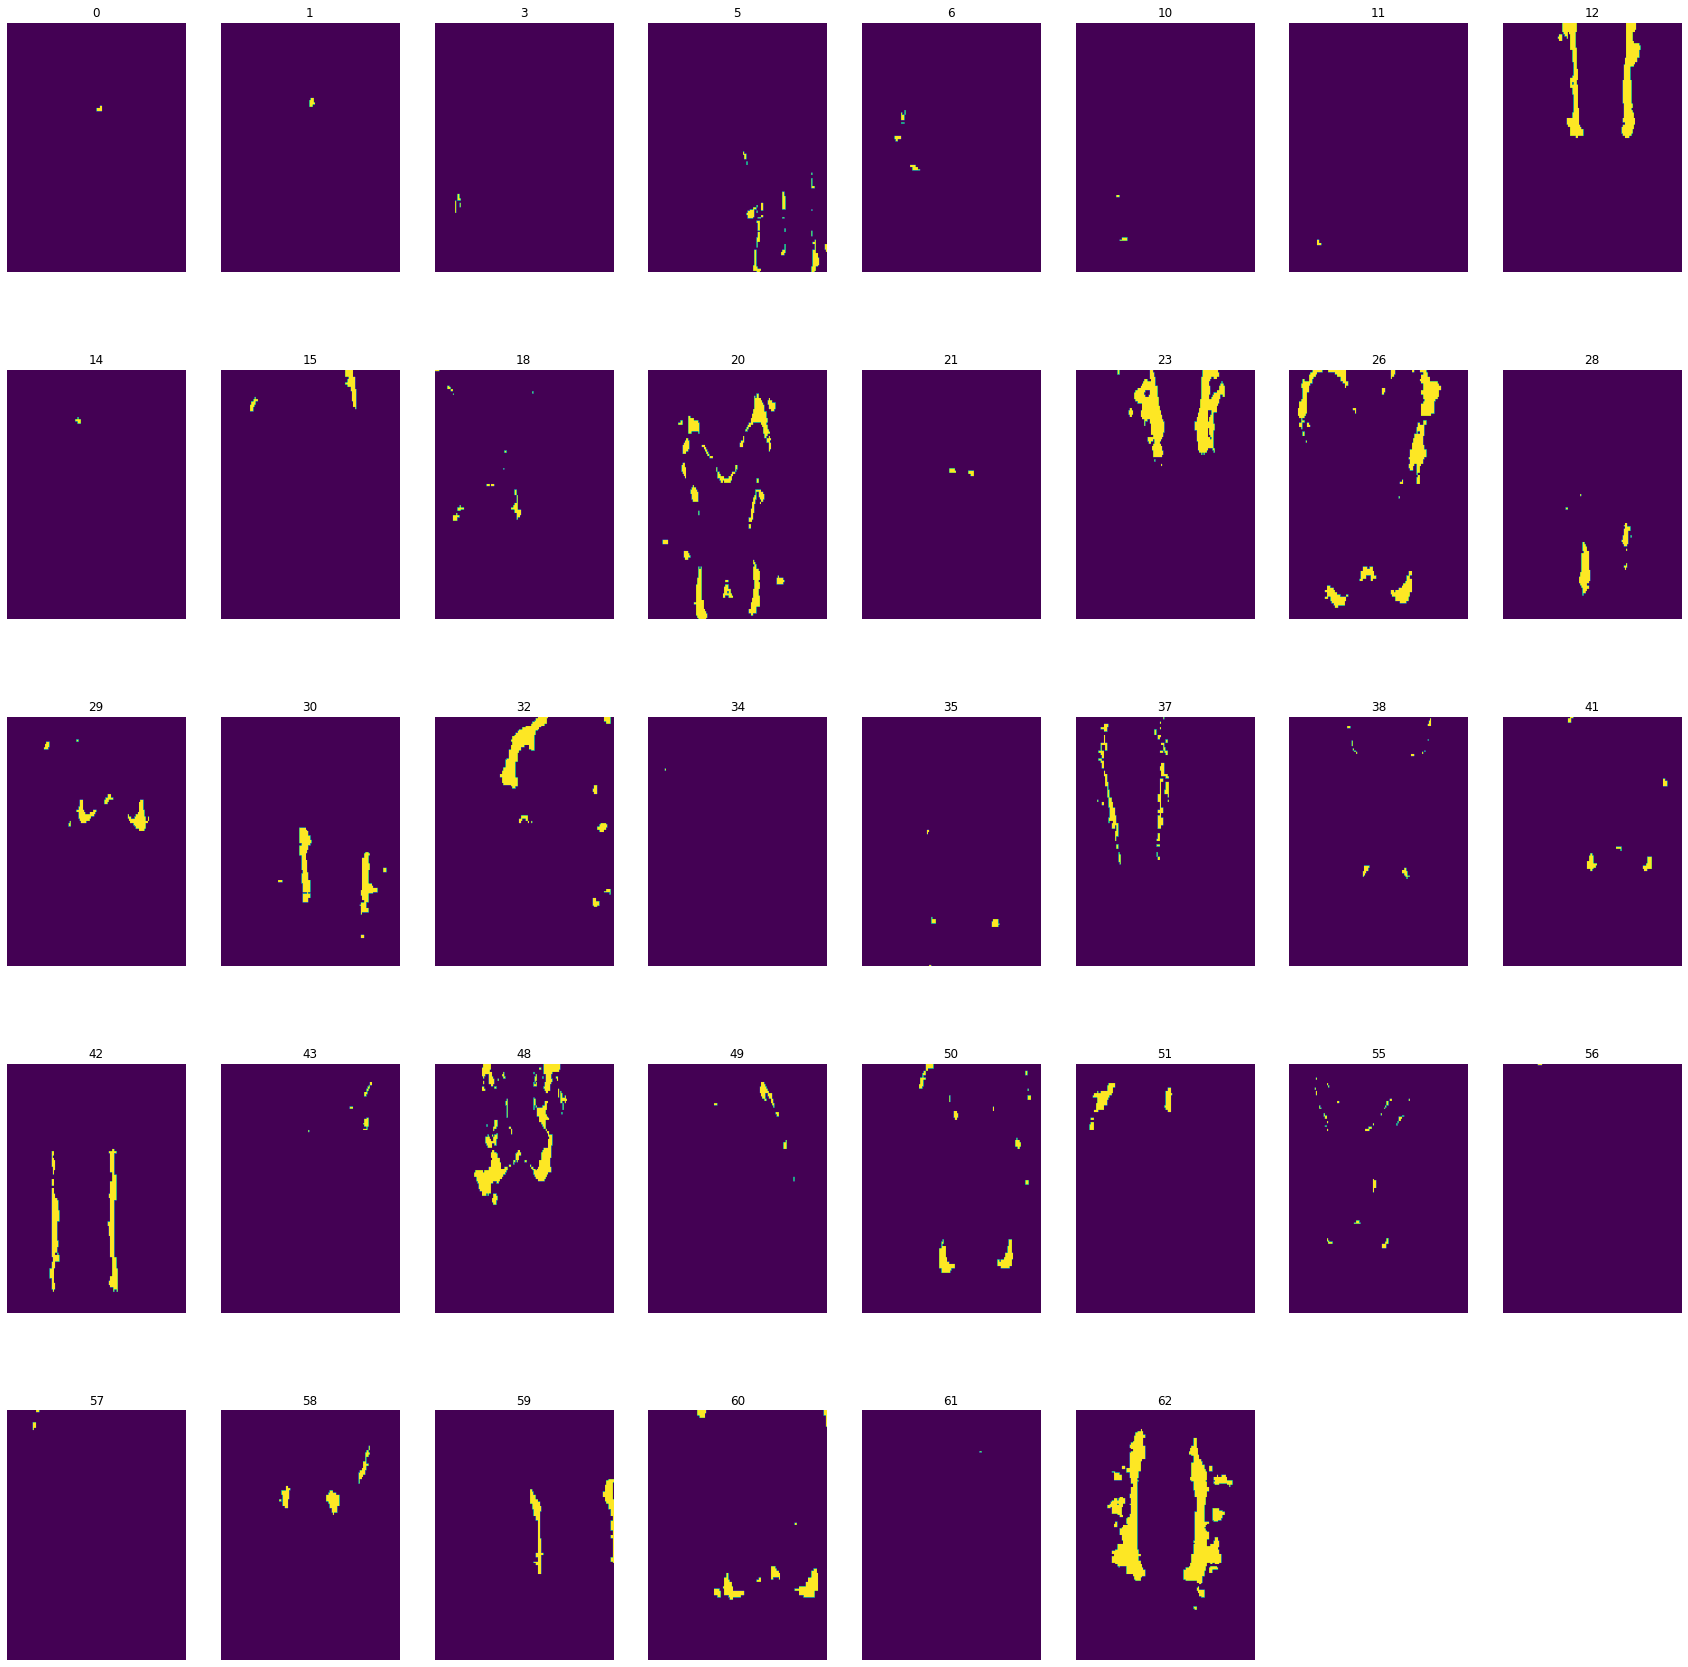

In [71]:
plt.figure(figsize=(30, 50))
count = 0
for i, img in enumerate(y):
    if torch.sum(img) > 0:
        plt.subplot(8, 8, count+1)
        plt.imshow(img); plt.axis('off');
        plt.title(i);
        count += 1
    

### look at calibrating the probability that a voxel is of class 1

In [72]:
from tqdm import tqdm

In [73]:
results = []
targets = []
ent_maps = []
dl = val_dataloader
with torch.no_grad():
    for x, y in tqdm(dl, total=len(dl), ncols=150, position=0, leave=True):
        pred = model.cuda()(x.cuda())
        samples = fixed_re_parametrization_trick(pred['distribution'], 14).cpu()
        results.append(samples)
        targets.append(y)
        ent_maps.append(entropy_map_from_samples(samples))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:15<00:00,  1.89s/it]


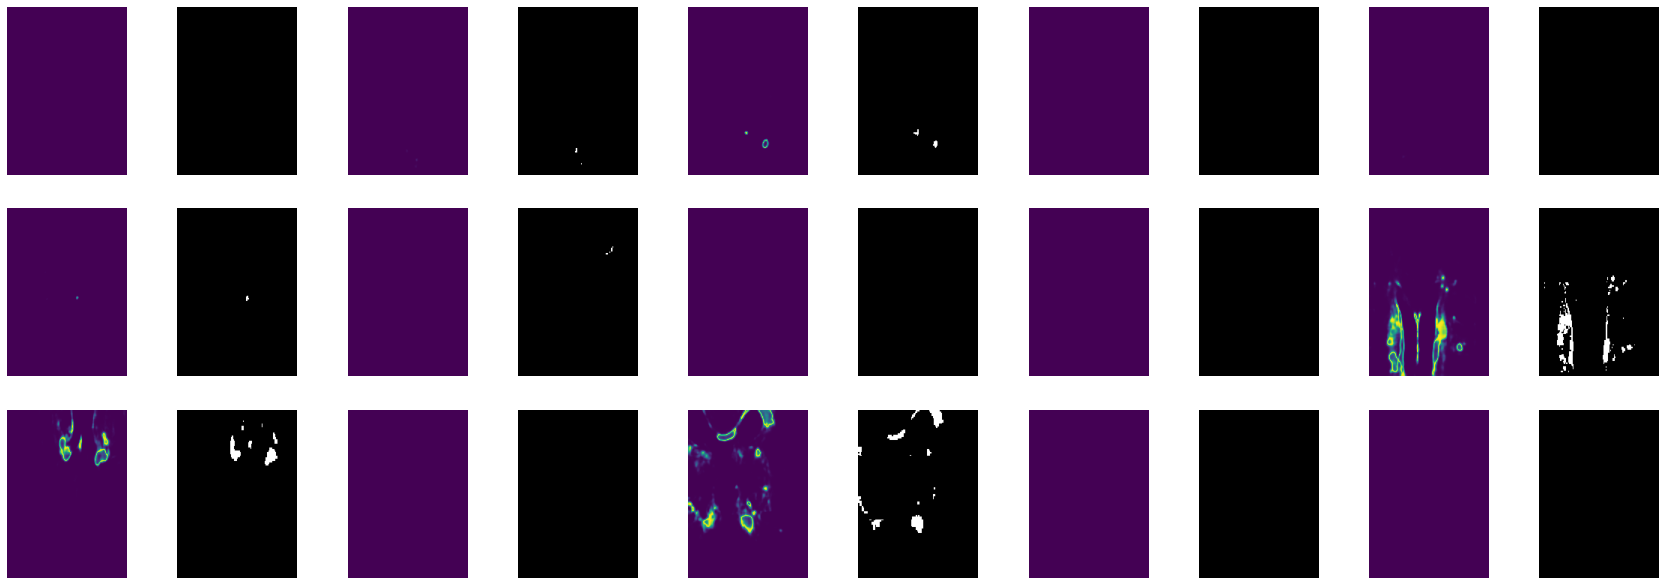

In [74]:
rand_inds_a = torch.randint(0, len(targets), (15,))
rand_inds_b = torch.randint(0, targets[0].shape[0], (15,))
plt.figure(figsize=(30, 10.5))
i = 0
for (ind_a, ind_b) in (zip(rand_inds_a, rand_inds_b)):
    plt.subplot(3, 10, i+1)
    batch = ent_maps[ind_a.item()]
    ind_b = ind_b.item()
    if batch.shape[0] <= ind_b:
        ind_b = batch.shape[0] - 1
    plt.imshow(batch[ind_b], cmap='viridis', vmin=0, vmax=0.7)
    plt.axis('off')
    
    plt.subplot(3, 10, i+2)
    plt.imshow(targets[ind_a][ind_b], cmap='gray')
    plt.axis('off')
    i += 2

In [75]:
rand_inds_a[6], rand_inds_b[6]

(tensor(8), tensor(36))

In [76]:
def place_in_bin(value):
    return torch.round(value, decimals=1)

In [77]:
def rolling_average(value, n, G):
    return value / n + ((n-1) / n) * G

def batch_rolling_average(values, n, G):
    """
    assumes all batches but the last batch are the same size
    """
    return values.sum() / (values.shape[0]*n) + ((n-1) / n) * G

In [78]:
# assess bin counts of p y = 1
bins = 10 + 1 # for the 0 bin
bin_batch_accuracies = [[] for b in range(bins)]
bin_batch_confidences = [[] for b in range(bins)]
bin_batch_sizes = [[] for b in range(bins)]
bin_counts = [0 for b in range(bins)]
for batch_idx in tqdm(range(len(targets)), ncols=150, position=0, leave=True): # skip the last batch with a different shape
    batch_t = targets[batch_idx]
    batch_samples = results[batch_idx]
    
    if batch_t.shape[0] < 10:
        continue # skip last batch if it is very small.
    
    # get probabilities
    probs = torch.nn.functional.softmax(batch_samples, dim=2)
    p1s = probs[:,:,1]
    
    # split into bins
    bin_ids = place_in_bin(p1s)
    
    # compute counts
    for i in range(bins):
        is_in_bin = (bin_ids == (i / 10))
        # print(is_in_bin.shape)
        # print(batch_t.shape)
        
        # number of elements in each bin
        num_elem = torch.sum(is_in_bin).item()
        if num_elem == 0:
            print("zero")
        
        # number of predictions = to class 1
        c1_acc = batch_t.expand(p1s.shape)[is_in_bin].sum() / num_elem
        
        if torch.isnan(c1_acc):
            print("acc_nan")
        
        # average confidence of values in that bin
        c1_conf = p1s[is_in_bin].mean()
        
        if torch.isnan(c1_conf):
            print("conf_nan")
        
        bin_batch_accuracies[i].append(c1_acc)
        bin_batch_confidences[i].append(c1_conf)
        bin_batch_sizes[i].append(num_elem)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [06:01<00:00,  9.03s/it]


In [79]:
bin_sizes = [torch.Tensor(bbs).sum() for bbs in bin_batch_sizes]
bin_accuracies = [torch.Tensor([bin_batch_accuracies[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_accuracies[i]))]).sum().item() for i in range(len(bin_sizes))]
bin_confidences = [torch.Tensor([bin_batch_confidences[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_confidences[i]))]).sum().item() for i in range(len(bin_sizes))]


In [80]:
bin_accuracies

[0.0010423450730741024,
 0.12151822447776794,
 0.19823160767555237,
 0.26059961318969727,
 0.3188929557800293,
 0.37982451915740967,
 0.44447287917137146,
 0.5178465843200684,
 0.6097438931465149,
 0.7373586893081665,
 0.9007626175880432]

In [81]:
bin_confidences

[0.00028135496540926397,
 0.08929403871297836,
 0.19543179869651794,
 0.2973804175853729,
 0.3985100984573364,
 0.4993208646774292,
 0.6001079678535461,
 0.7010433673858643,
 0.8026668429374695,
 0.9071277379989624,
 0.9848486185073853]

In [82]:
"""
looking at just the class one calibration is useful due to the extreme lack of class 1 in the image, this gives us a better idea of how the model is doing
and when optimizing calibration I should be optimizing this.
"""

'\nlooking at just the class one calibration is useful due to the extreme lack of class 1 in the image, this gives us a better idea of how the model is doing\nand when optimizing calibration I should be optimizing this.\n'

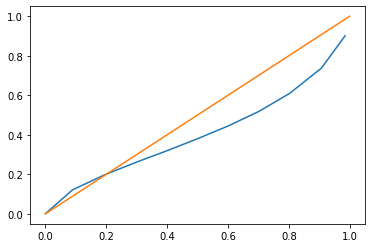

In [83]:
plt.plot(bin_confidences, bin_accuracies)
plt.plot([0,1],[0,1]);

In [84]:
exd = batch_t.expand(p1s.shape)

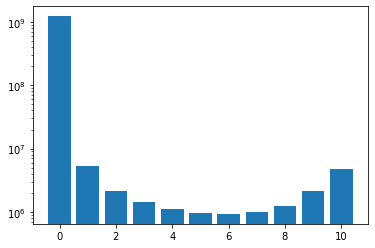

In [85]:
plt.bar([i for i in range(bins)], torch.Tensor(bin_sizes), align='center')
plt.yscale("log")

In [86]:
# now assess true calibration
bins = 10 + 1 # for the 0 bin
bin_batch_accuracies = [[] for b in range(bins)]
bin_batch_confidences = [[] for b in range(bins)]
bin_batch_sizes = [[] for b in range(bins)]
bin_counts = [0 for b in range(bins)]
for batch_idx in tqdm(range(len(targets)), ncols=150, position=0, leave=True): # skip the last batch with a different shape
    batch_t = targets[batch_idx]
    batch_samples = results[batch_idx]
    
    if batch_t.shape[0] < 10:
        continue # skip last batch if it is very small.
    
    # get probabilities
    probs = torch.nn.functional.softmax(batch_samples, dim=2)
    pred_classes = probs.argmax(dim=2)
    confidences = probs.max(dim=2)[0]
    
    # split into bins
    bin_ids = place_in_bin(confidences)
    
    # compute counts
    for i in range(bins):
        is_in_bin = (bin_ids == (i / 10))
        # print(is_in_bin.shape)
        # print(batch_t.shape)
        
        # number of elements in each bin
        num_elem = torch.sum(is_in_bin).item()
        
        # number of predictions = to class 1
        c1_acc = (batch_t.expand(pred_classes.shape)[is_in_bin] == pred_classes[is_in_bin]).sum() / num_elem
        
        # average confidence of values in that bin
        c1_conf = confidences[is_in_bin].mean()
        
        bin_batch_accuracies[i].append(c1_acc)
        bin_batch_confidences[i].append(c1_conf)
        bin_batch_sizes[i].append(num_elem)
    # 

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 36/40 [08:20<00:55, 13.90s/it]


KeyboardInterrupt: 

In [ ]:
bin_sizes = [torch.Tensor(bbs).sum() for bbs in bin_batch_sizes]
bin_accuracies = [torch.Tensor([bin_batch_accuracies[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_accuracies[i]))]).sum().item() for i in range(len(bin_sizes))]
bin_confidences = [torch.Tensor([bin_batch_confidences[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_confidences[i]))]).sum().item() for i in range(len(bin_sizes))]

In [ ]:
plt.plot(bin_confidences, bin_accuracies)
plt.plot([0,1],[0,1])

In [ ]:
plt.bar([i for i in range(bins)], torch.Tensor(bin_sizes), align='center')
plt.yscale("log")

### Compute the PavPU metrics cause I'm not convinced my previous code in original ssn notebook was incorrect.

In [ ]:
# I am going to do it per patch, but take the average accuracy per patch (perhaps I should qc average dice as well, best dice, worst dice.
uncetainty_thresholds = torch.arange(0, 0.7, 0.01)
accuracy_threshold = 0.9
window = 8
stride = 8
n_acs = [[] for i in range(len(uncetainty_thresholds))]
n_aus = [[] for i in range(len(uncetainty_thresholds))]
n_ics = [[] for i in range(len(uncetainty_thresholds))]
n_ius = [[] for i in range(len(uncetainty_thresholds))]

for batch_idx in tqdm(range(len(targets)), ncols=150, position=0, leave=True): # skip the last batch with a different shape
    batch_t = targets[batch_idx]
    batch_samples = results[batch_idx]
    ent = ent_maps[batch_idx]
    
    # get probabilities
    probs = torch.nn.functional.softmax(batch_samples, dim=2)
    pred_classes = probs.argmax(dim=2)
    confidences = probs.max(dim=2)[0]
    
    # get average accuracy of each sample
    # or I could treat each patch of each sample as a separate thing but that is not what I am doing here.
    avg_accuracy = ((batch_t.expand(pred_classes.shape) == pred_classes) * 1.).mean(dim=0)
    
    # unroll predictions and targets and entropy
    t_unrolled = batch_t.unfold(-2, window, stride).unfold(-1, window, stride).reshape(-1, window, window)
    accuracy_unrolled = avg_accuracy.unfold(-2, window, stride).unfold(-1, window, stride).reshape(-1, window, window)
    ent_unrolled = ent.unfold(-2, window, stride).unfold(-1, window, stride).reshape(-1, window, window)
    
    accurate_patches = accuracy_unrolled > 0.9
    
    # for each uncertainty threshold, compute the 4 numbers
    for i, uncert_t in enumerate(uncetainty_thresholds):
        uncertain_patches = ent_unrolled > uncert_t
        
        n_acs[i].append(torch.sum(torch.logical_and(accurate_patches, ~uncertain_patches)))
        n_aus[i].append(torch.sum(torch.logical_and(accurate_patches, uncertain_patches)))
        n_ics[i].append(torch.sum(torch.logical_and(~accurate_patches, ~uncertain_patches)))
        n_ius[i].append(torch.sum(torch.logical_and(~accurate_patches, uncertain_patches)))
        

In [ ]:
n_acs_t = [torch.Tensor(n_acs[i]).sum() for i in range(len(uncetainty_thresholds))]
n_aus_t = [torch.Tensor(n_aus[i]).sum() for i in range(len(uncetainty_thresholds))]
n_ics_t = [torch.Tensor(n_ics[i]).sum() for i in range(len(uncetainty_thresholds))]
n_ius_t = [torch.Tensor(n_ius[i]).sum() for i in range(len(uncetainty_thresholds))]

In [ ]:
p_acs = [n_acs_t[i] / (n_acs_t[i] + n_ics_t[i]) for i in range(len(uncetainty_thresholds))]
p_aus = [n_ius_t[i] / (n_ius_t[i] + n_ics_t[i]) for i in range(len(uncetainty_thresholds))]
pavpu = [(n_acs_t[i] + n_ius_t[i]) / (n_ius_t[i] + n_ics_t[i] + n_aus_t[i] + n_acs_t[i]) for i in range(len(uncetainty_thresholds))]

In [ ]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.plot(uncetainty_thresholds, p_acs)
plt.subplot(1,3,2)
plt.plot(uncetainty_thresholds, p_aus)
plt.subplot(1,3,3)
plt.plot(uncetainty_thresholds, pavpu)

### Look at the same metrics but for domain adaption now

In [ ]:
domains2 = [
            wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
          ]

# domains = [
#             wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
#           ] + [
#             ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
#           ]


# domains = [
#             ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
#           ]

In [ ]:
# load datasets
# this step is quite slow, all the data is being loaded into memory
if is3D:
    datasets_domains2 = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is_3D=True)) for domain in domains2]
else:
    datasets_domains2 = [MRISegmentation2DDataset(root_dir, domain, transforms=get_transforms(is_3D=False)) for domain in domains2]

# split into train, val test datasets
datasets2 = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains2]

# concat the train val test datsets
train_dataset2 = ConcatDataset([ds[0] for ds in datasets2])
val_dataset2 = ConcatDataset([ds[1] for ds in datasets2])
test_dataset2 = ConcatDataset([ds[2] for ds in datasets2])

In [ ]:
len(train_dataset2), len(val_dataset2), len(test_dataset2)

In [ ]:
# define dataloaders
train_dataloader2 = DataLoader(train_dataset2, batch_size=64, shuffle=True, num_workers=4)
test_dataloader2 = DataLoader(test_dataset2, batch_size = 16, shuffle=False, num_workers=4)
val_dataloader2 = DataLoader(val_dataset2, batch_size=64, shuffle=False, num_workers=4)

In [ ]:
def entropy_map_from_samples(samples):
    "samples is of shape samples, batch size, channels, image dims  [s, b, c *<dims>]"
    probs = torch.nn.functional.softmax(samples, dim=2)
    pic = torch.mean(probs, dim=0)
    ent_map = torch.sum(-pic * torch.log(pic+1e-30), dim=1)
    
    return ent_map

In [ ]:
from tqdm import tqdm

In [ ]:
all_tps = []
all_tns = []
all_fps = []
all_fns = []

with torch.no_grad():
    for x, y in tqdm(val_dataloader2, position=0, leave=True, ncols=150):
        pred = model(x)
        samples = fixed_re_parametrization_trick(pred['distribution'], 14).cpu()
        ent = entropy_map_from_samples(samples).view([-1])
        mean = pred['logit_mean']
        mean_class = mean.argmax(dim=1).view(-1)
        y_flat = y.view(-1)
        
        tp_loc = torch.where(torch.logical_and(y_flat == 1, mean_class == 1))[0]
        tn_loc = torch.where(torch.logical_and(torch.logical_and(y_flat == 0, mean_class == 0), x[:,1].reshape(-1) == 1))[0]
        fp_loc = torch.where(torch.logical_and(y_flat == 0, mean_class == 1))[0]
        fn_loc = torch.where(torch.logical_and(torch.logical_and(y_flat == 1, mean_class == 0), x[:,1].reshape(-1) == 1))[0]
        # print(tp_loc.shape)
        # print(ent.view(-1).shape)
        
        all_tps.append(ent[tp_loc])
        all_tns.append(ent[tn_loc])
        all_fps.append(ent[fp_loc])
        all_fns.append(ent[fn_loc])

In [ ]:
tps = torch.cat(all_tps)
tns = torch.cat(all_tns)
fps = torch.cat(all_fps)
fns = torch.cat(all_fns)

In [ ]:
tps.shape, tns.shape, fps.shape, fns.shape

In [ ]:
tps.mean(), tns.mean(), fps.mean(), fns.mean()

In [ ]:
plt.hist(tps, bins=100);

In [ ]:
#plt.hist(tns, bins=100);

In [ ]:
plt.hist(fps, bins=100);

In [ ]:
plt.hist(fns, bins=100);

### count the number of missing lesions per image. DOMAIN ADAPTED CASE!!

In [ ]:
from typing import Dict, Tuple

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np
import kornia as K

def create_random_labels_map(classes: int) -> Dict[int, Tuple[int, int, int]]:
    labels_map: Dict[int, Tuple[int, int, int]] = {}
    for i in classes:
        labels_map[i] = torch.randint(0, 255, (3, ))
    labels_map[0] = torch.zeros(3)
    return labels_map

def labels_to_image(img_labels: torch.Tensor, labels_map: Dict[int, Tuple[int, int, int]]) -> torch.Tensor:
    """Function that given an image with labels ids and their pixels intrensity mapping, creates a RGB
    representation for visualisation purposes."""
    assert len(img_labels.shape) == 2, img_labels.shape
    H, W = img_labels.shape
    out = torch.empty(3, H, W, dtype=torch.uint8)
    for label_id, label_val in labels_map.items():
        mask = (img_labels == label_id)
        for i in range(3):
            out[i].masked_fill_(mask, label_val[i])
    return out

def show_components(img, labels):
    color_ids = torch.unique(labels)
    labels_map = create_random_labels_map(color_ids)
    labels_img = labels_to_image(labels, labels_map)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))
    
    # Showing Original Image
    ax1.imshow(img)
    ax1.axis("off")
    ax1.set_title("Orginal Image")
    
    #Showing Image after Component Labeling
    ax2.imshow(labels_img.permute(1,2,0).squeeze().numpy())
    ax2.axis('off')
    ax2.set_title("Component Labeling")

In [ ]:
ys = []
conncomp_outs = []
ents_out = []
means_out = []
with torch.no_grad():
    for x, y in tqdm(val_dataloader2, position=0, leave=True, ncols=150):
        labels_out = K.contrib.connected_components(y.unsqueeze(1).type(torch.float32), num_iterations=150)
        conncomp_outs.append(labels_out)
        ys.append(y)

        pred = model.cuda()(x.cuda())
        samples = fixed_re_parametrization_trick(pred['distribution'], 14).cpu()
        ents_out.append(entropy_map_from_samples(samples))
        means_out.append(pred['logit_mean'].cpu())

In [ ]:
missing_lesion_size_ent = []
existing_lesion_size_ent = []
missing_lesion_size_mean = []
existing_lesion_size_mean = []
for batch in tqdm(range(len(ys)), position=0, leave=True, ncols=150):
    for i in range(ys[batch].shape[0]):
        conncomps = conncomp_outs[batch][i]
        ent = ents_out[batch][i]
        ent_thresh = (ent > 0.1).type(torch.long)
        mean = means_out[batch][i].argmax(dim=0).type(torch.long)
        
        ids = conncomps.unique()[1:]
        for idx in ids:
            cc = (conncomps == idx)
            size = torch.sum(cc)
            if torch.max(mean * cc) > 0:
                existing_lesion_size_mean.append(size)
            else:
                missing_lesion_size_mean.append(size)
            
            if torch.max(ent_thresh * cc) > 0:
                existing_lesion_size_ent.append(size)
            else:
                missing_lesion_size_ent.append(size)

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(2,2,1)
plt.hist(existing_lesion_size_ent, bins=200);
plt.xscale('log')
plt.subplot(2,2,2)
plt.hist(missing_lesion_size_ent, bins=200);
plt.xscale('log')

plt.subplot(2,2,3)
plt.hist(existing_lesion_size_mean, bins=200);
plt.xscale('log')
plt.subplot(2,2,4)
plt.hist(missing_lesion_size_mean, bins=200);
plt.xscale('log')

### Trying again to look at per slice dice and quality control in 2d

### Look at baselines for interactive learning now I have a better idea of how to do it

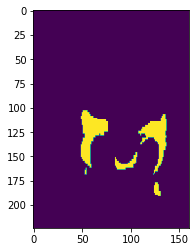

In [115]:
# how to find largest areas which are
plt.imshow(targets[18][46])

In [119]:
summer = torch.nn.Conv2d(1, 1, 3, padding='same', bias=False)
summer.weight.data = torch.ones(summer.weight.data.shape)

In [136]:
img = targets[18][46].unsqueeze(0).unsqueeze(0).type(torch.float32)

In [213]:
s1 = results[18][0][46]
s2 = results[18][1][46]

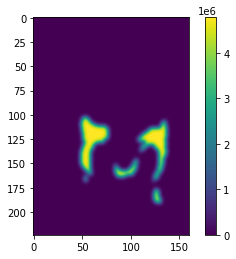

In [176]:
n = 7
with torch.no_grad():
    out = img
    for i in range(n):
        out = summer(out)
plt.imshow(out.squeeze())
plt.colorbar()

In [177]:
# efficient global maxima is to compute max pool 2d and see which pixels stay the same
mp = torch.nn.functional.max_pool2d(out, kernel_size=5,stride=1, padding=2)

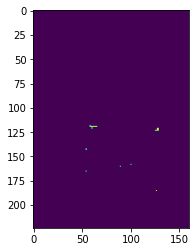

In [178]:
plt.imshow(torch.logical_and(out == mp, out > 1e-1).squeeze())

In [ ]:
# building the consistency loss that says points near a label should be similar
# so I should do the cross entropy loss multiplied by the distance between annotated points (and I should probably weight this in some way), along with a consistency loss

# building the consistency losses
# should be distance between annotations informing incorrectness plus closeness (1-distance?) to annotations informing correctness.

In [196]:
x = torch.arange(0, 224, 1)
y = torch.arange(0, 160, 1)
xs, ys = torch.meshgrid(x, y, indexing='ij')
grid = torch.stack([xs, ys], dim=0)

points = torch.Tensor([[50,75], [200,100], [100,149]])
grid_points = grid.permute(1,2,0)

def get_grid():
    x = torch.arange(0, 224, 1)
    y = torch.arange(0, 160, 1)
    xs, ys = torch.meshgrid(x, y, indexing='ij')
    grid = torch.stack([xs, ys], dim=0)
    return grid

def dist(values, point):
    return torch.sqrt((values[0] - point[0]) ** 2. + (values[1] - point[1]) ** 2.)

def dists_all(values, points):
    return torch.stack([dist(grid, p) for p in points])

In [197]:
dists = torch.stack([dist(grid, p) for p in points])

In [249]:
min_dist

tensor([[ 90.1388,  89.3085,  88.4816,  ...,  96.0417,  96.8969,  97.7548],
        [ 89.5879,  88.7525,  87.9204,  ...,  95.5249,  96.3846,  97.2471],
        [ 89.0449,  88.2043,  87.3670,  ...,  95.0158,  95.8801,  96.7471],
        ...,
        [102.1812, 101.2028, 100.2247,  ...,  60.7454,  61.6847,  62.6259],
        [102.3914, 101.4150, 100.4390,  ...,  61.0983,  62.0322,  62.9682],
        [102.6109, 101.6366, 100.6628,  ...,  61.4654,  62.3939,  63.3246]])

In [265]:
min_dist = dists.min(dim=0)[0]

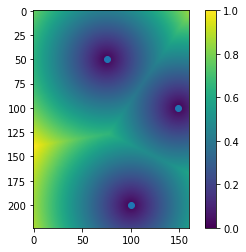

In [270]:
plt.imshow((min_dist/torch.max(min_dist))**1)
plt.colorbar()
plt.scatter(points[:,1], points[:,0]);

In [ ]:
# so the l1 loss should be multiplied by the max of (distance from incorrect points in the annotation, closeness to corrent points in the annotatoin)
# along with the cross entropy loss that is multiplied by the closeness to all annotated points.

# as for the baselines
# i can pick two baselines, one where incorrect points are picked randomly (along with a few random correct points picked)
# or, I can pick points either that are most correct or most incorrect, where I define 'most' by doing the convolution sum n times and picking the pixels
# that are the biggest (find the global maxima) using the policy that I outlined above. I can compare these baselines to using the uncertainty to guide which
# points should be picked by the user.

# the uncertainty model uses maximum uncertainty to suggest to the user the best locations to be annotated. I should add some annotation noise by moving the point slightly.

In [ ]:
def proximity_l1(y_update, y_orig, incorrect_annotations, correct_annotations, lambda_inc, lambda_corr):
    l1_loss = torch.nn.functional.l1_loss(y_update, y_orig, reduction='none')
    grid = get_grid()
    incorrect_dists = dists_all(grid, incorrect_annotations).min(dim=0)[0]
    correct_dists = dists_all(grid, correct_annotations).min(dim=0)[0]
    
    # get max of closeness to correct annotation factor * distance from incorrect annotation factor.
    rectified_l1 = l1_loss * torch.maximum((incorrect_dists/torch.max(incorrect_dists)) ** lamba_inc, (1.- (correct_dists/torch.max(correct_dists))**lambda_corr))
    
    return rectified_l1.mean()


def proximity_cross_entropy(y_pred, y_true, class_weight, annotations, lambda_proximity):
    xent_loss = torch.nn.functional.cross_entropy(y_pred, y_true, weight=class_weight, reduction='none')
    
    point_proximity = dists_all(grid, annotations).min(dim=0)[0]
    
    rectified_xent = xent_loss * ((point_proximity/point_proximity.max()) ** lambda_proximity)
    
    return rectified_xent.mean()

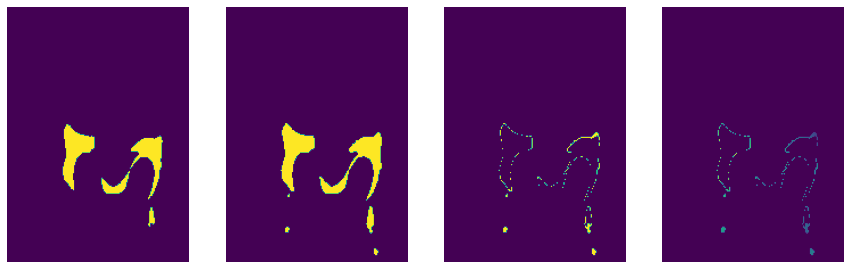

In [260]:
plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
plt.imshow(s2.argmax(dim=0)); plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(s1.argmax(dim=0));plt.axis('off');
plt.subplot(1,4,3)
plt.imshow(torch.nn.functional.l1_loss(s1.argmax(dim=0), s2.argmax(dim=0), reduction='none')); plt.axis('off');
plt.subplot(1,4,4)
plt.imshow(torch.nn.functional.l1_loss(s1.argmax(dim=0), s2.argmax(dim=0), reduction='none') * ((min_dist/torch.max(min_dist))**1).type(torch.float32)); plt.axis('off');

### Look at quality controlling the uncertainty in 3D

### Plots

In [79]:
def actual_dice(y_hat, y_true):
    y_hat = torch.nn.functional.softmax(y_hat, dim=1).argmax(dim=1)
    # count how many times the ground truth and target have nothing in them
    s0 = y_hat.shape[0]
    y_hat = y_hat.view(s0, -1)
    y_true = y_true.view(s0, -1)
    # print(torch.sum(torch.sum(y_true, dim=1) == 0))
    # print(torch.sum(torch.sum(y_hat, dim=1) == 0))
    # print(torch.sum(torch.logical_and(torch.sum(y_hat, dim=1) == 0, torch.sum(y_true, dim=1) == 0)))
    ignores = torch.sum(torch.logical_and(torch.sum(y_hat, dim=1) == 0, torch.sum(y_true, dim=1) == 0))
    
    
    numerator = torch.sum(2 * y_true * y_hat, dim=1)
    # print(numerator)
    denominator = torch.sum(y_true + y_hat, dim=1)
    # print(denominator)
    
    return torch.sum((numerator) / (denominator + 1e-8)) / (s0-ignores) # s0

In [80]:
def slice_dice(y_hat, y_true):
    y_hat = torch.nn.functional.softmax(y_hat, dim=0).argmax(dim=0)
    
    if torch.sum(y_hat) == 0 and torch.sum(y_true) == 0:
        return "n/a"
    
    numerator = torch.sum(2 * y_hat * y_true)
    denominator = torch.sum(y_hat + y_true)
    return numerator / (denominator + 1e-8)

In [81]:
def dice(y_pred, y_true):
    y_pred = torch.nn.functional.softmax(y_pred, dim=1).argmax(dim=1)
    denominator = torch.sum(y_pred) + torch.sum(y_true)
    numerator = 2. * torch.sum(torch.logical_and(y_pred, y_true))
    return numerator / denominator

In [82]:
ssn_diceloss(y_hat, y1.to(y_hat['logit_mean'].device))

tensor(0.2633)

In [83]:
mc_loss(y_hat, y1.to(y_hat['logit_mean'].device))

tensor(194.5317)

In [84]:
samples = fixed_re_parametrization_trick(y_hat['distribution'], 20)
probs = torch.nn.functional.softmax(samples, dim=2)
pic = torch.mean(probs, dim=0)
ent_map = torch.sum(-pic * torch.log(pic+1e-30), dim=1).cpu()

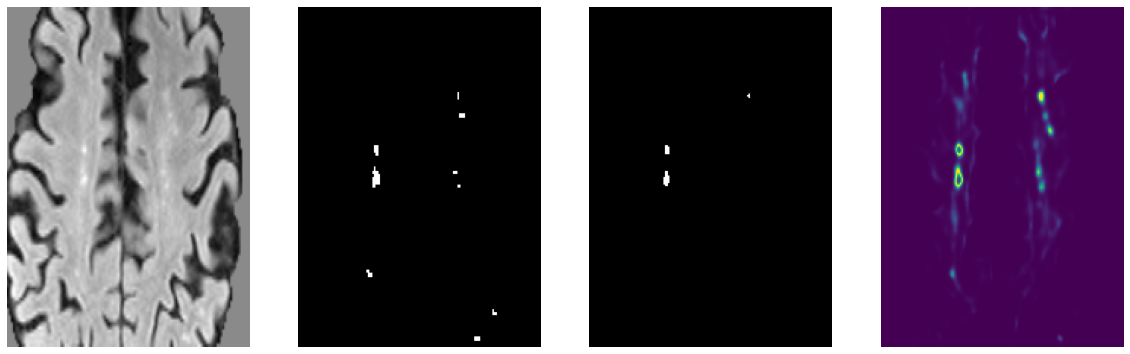

In [85]:
ind = 50
plt.figure(figsize=(20,7))
plt.subplot(1,4,1)
plt.imshow(x1[ind][0,:,:],cmap='gray'); plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(y1[ind], cmap='gray'); plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(torch.nn.functional.softmax(y_hat['logit_mean'].cpu(), dim=1).argmax(dim=1)[ind], cmap='gray'); plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(ent_map[ind]); plt.axis('off')
#print(slice_dice(y_hat['logit_mean'].cpu()[ind], y1[ind]))
plt.show()

In [102]:
with torch.no_grad():
    steps = 5
    device = wrapped_interact_model.device
    new_result, update_maps, means = wrapped_interact_model(x1.to(device), y1.to(device), steps-1, diagnostic=True)

In [103]:
samples1 = fixed_re_parametrization_trick(new_result['distribution'], 20)
probs1 = torch.nn.functional.softmax(samples1, dim=2)
pic1 = torch.mean(probs1, dim=0)
ent_map1 = torch.sum(-pic1 * torch.log(pic1+1e-30), dim=1).cpu()

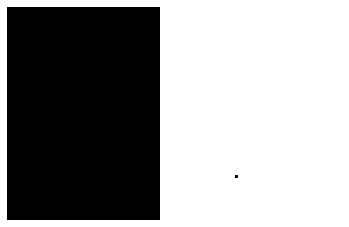

In [104]:
plt.subplot(1,2,1)
plt.imshow(update_maps[0][ind][0], cmap='gray'); plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(update_maps[0][ind][1], cmap='binary'); plt.axis('off');

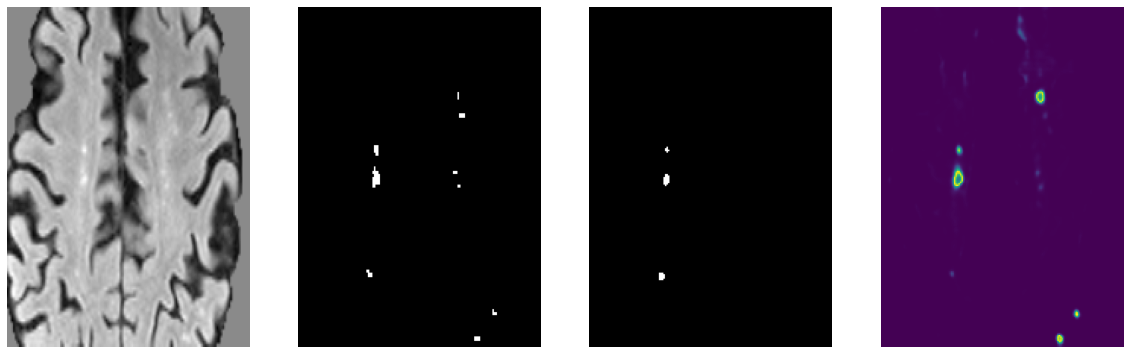

In [114]:
plt.figure(figsize=(20,7))
plt.subplot(1,4,1)
plt.imshow(x1[ind][0,:,:],cmap='gray'); plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(y1[ind], cmap='gray'); plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(torch.nn.functional.softmax(means[0].cpu(), dim=1).argmax(dim=1)[ind], cmap='gray'); plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(ent_map1[ind]); plt.axis('off')
#print(slice_dice(y_hat['logit_mean'].cpu()[ind], y1[ind]))
plt.show()

tensor(0.5152)


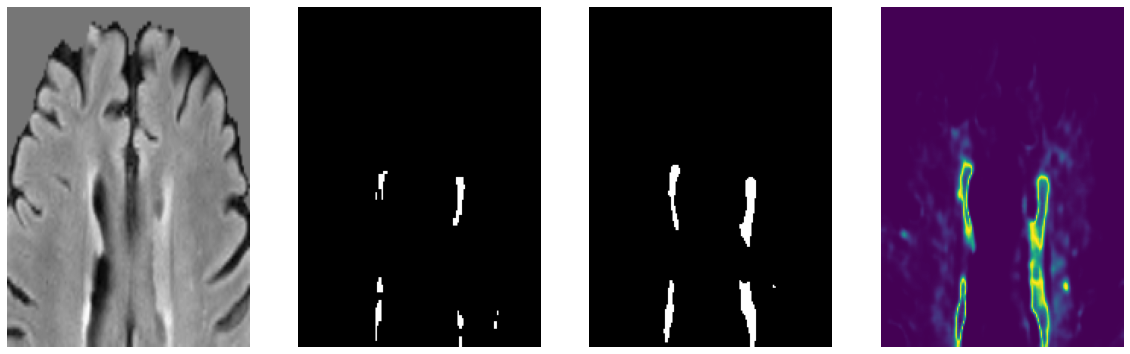

In [68]:
ind = 16#16 #27
plt.figure(figsize=(20,7))
plt.subplot(1,4,1)
plt.imshow(x1[ind][0,:,:],cmap='gray'); plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(y1[ind], cmap='gray'); plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(torch.nn.functional.softmax(y_hat['logit_mean'].cpu(), dim=1).argmax(dim=1)[ind], cmap='gray'); plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(ent_map[ind]); plt.axis('off')
print(slice_dice(y_hat['logit_mean'].cpu()[ind], y1[ind]))
plt.show()

### Building the interactive model


### TODO
- need to filter out slices where the prediction exactly matches the target I guess.
- note that the distribution of true positive and false positive is not balanced at all so may need to do some clever sampling here.
- reweight new predictions in the training data. Need a mechanism for doing this, say once an epoch (im not sure it should be reweighted though actually, because otherwise it will just converge to the new stuff later on, so randomly sample from the whole lot actually is my view. Nice.
- extra augmentations impelment to prevent overfitting on the small validation data
- custom fitter code to run all of this.

In [78]:
y_pred = torch.nn.functional.softmax(y_hat['logit_mean'].cpu(), dim=1).argmax(dim=1)

In [328]:
ind = 17
y_pred_slice = y_pred[ind]
y1_slice = y1[ind]
diff = y_pred_slice != y1_slice
where = torch.where(diff)

update_point = torch.randint(0, len(where[0]), (1,)).item()

In [398]:
umap = generate_update_filter(y_pred_slice, y1_slice, 3)

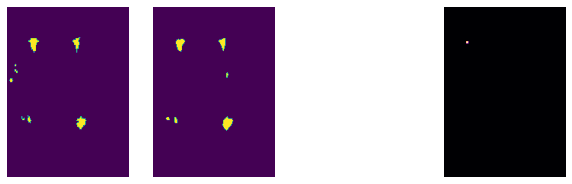

In [399]:
plt.figure(figsize=(10,4))
plt.subplot(1,4,1)
plt.imshow(y1[ind]); plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(y_pred[ind]);plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(umap[0], cmap='binary'); plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(umap[1], cmap='magma'); plt.axis('off');